In [ ]:
!pip install mlxtend

In [3]:
import numpy as np
import pandas as pd
from mlxtend.plotting import plot_decision_regions
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Импорт данных

In [5]:
df = pd.read_csv('../data/pima/diabetes.csv')

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Выбор признаков

In [6]:
df.corr().Outcome.to_frame().style.background_gradient()

,Outcome
Pregnancies,0.221898
Glucose,0.466581
BloodPressure,0.065068
SkinThickness,0.074752
Insulin,0.130548
BMI,0.292695
DiabetesPedigreeFunction,0.173844
Age,0.238356
Outcome,1.000000


Выберем два признака, чтоб было нагляднее при визуализации decision boundary классифиукатора.

In [7]:
X = df[['Glucose', 'Age']]
y = df['Outcome']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

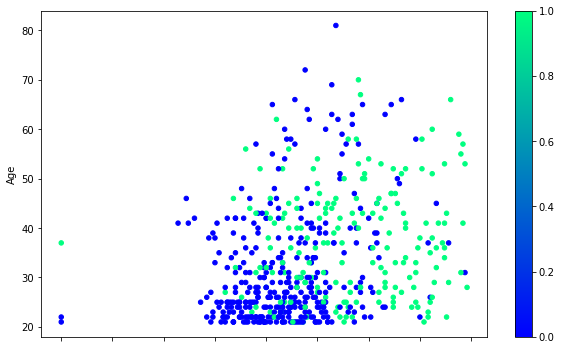

In [9]:
X_train.plot.scatter(x='Glucose', y='Age', c=y_train, cmap='winter', figsize=(10,6));

# kNN

## kNN вручную

Пусть К=5 и нам надо определить класс нового объекта.

In [26]:
K=5

Определяем данные.

In [15]:
new_object = [1,2,3]
train_objects = np.random.randn(100,3)

Определим лейблы классов в обучающем наборе.

In [23]:
y_train = np.random.choice([1,2,3], size=100)

In [24]:
y_train

array([3, 2, 1, 2, 2, 1, 2, 3, 1, 2, 3, 3, 3, 2, 3, 2, 2, 3, 1, 3, 3, 1,
       2, 3, 2, 3, 1, 2, 1, 3, 2, 3, 2, 1, 1, 3, 1, 1, 1, 1, 3, 3, 1, 1,
       2, 3, 1, 2, 2, 2, 2, 3, 2, 3, 3, 1, 3, 1, 3, 1, 3, 1, 1, 1, 2, 1,
       3, 3, 2, 1, 2, 1, 2, 1, 2, 3, 2, 3, 3, 2, 1, 2, 2, 2, 1, 1, 1, 1,
       3, 2, 3, 1, 2, 2, 3, 1, 2, 1, 2, 3])

Находим расстояние Минковского от всех наших объектов до нового.

In [16]:
distances = [np.sqrt(np.sum((obj - new_object)**2)) for obj in train_objects]

Отранжируем расстояния и найдём К ближайших к новому объекту. Для начала найдё индексы этих топ К ближайших соседей.

In [34]:
top_k_indices = sorted(range(len(distances)), key=lambda i: distances[i])[:K]

In [36]:
top_k_indices

[94, 79, 11, 54, 2]

Посмотрим, какие расстояния имеют ближайшие объекты.

In [35]:
np.array(distances)[top_k_indices]

array([1.78512022, 1.92428432, 1.99362488, 2.02094898, 2.02984789])

И выведем, какие классы у ближайших объектов:

In [39]:
top_k_classes = np.array(y_train)[top_k_indices]
top_k_classes

array([3, 2, 3, 3, 1])

In [42]:
unique, counts = np.unique(top_k_classes, return_counts=True)

In [43]:
dict(zip(unique, counts))

{1: 1, 2: 1, 3: 3}

Итого, самый частотный в ответе класс - это и будет класс нового объекта.

## kNN с sklearn

По умолчанию в kNN используется расстояние Минковского p=2 (оно же - эвклидово расстояние):
https://en.wikipedia.org/wiki/Minkowski_distance

Подберём лучшее количество соседей.

In [4]:
knn = KNeighborsClassifier()
params_knn = {'n_neighbors': np.arange(1, 25)}
knn_gs = GridSearchCV(knn, params_knn, cv=5)
knn_gs.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [55]:
knn_best = knn_gs.best_estimator_

print(knn_gs.best_params_, knn_gs.best_score_)

{'n_neighbors': 8} 0.7802007615091726


In [56]:
knn_gs.best_estimator_

KNeighborsClassifier(n_neighbors=8)

In [57]:
knn_best = knn_gs.best_estimator_

Два способа, как можем отобразить decision boundary:

/Users/hanna.pylieva/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


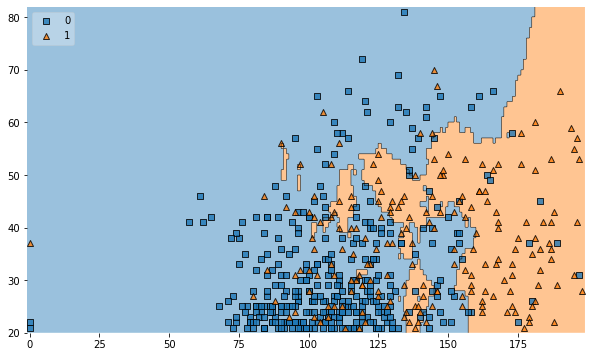

In [58]:
from mlxtend.plotting import plot_decision_regions

plt.figure(figsize=(10,6))
plot_decision_regions(X_train.values, y_train.values, clf=knn_best, legend=2);

In [59]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    plt.figure(figsize=(10,6))
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap,
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

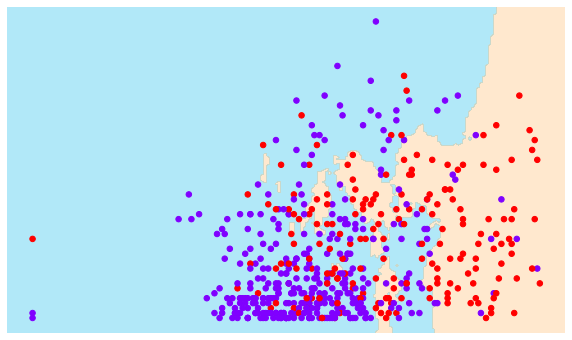

In [60]:
visualize_classifier(knn_best, X_train.values, y_train.values);

In [61]:
y_test_pred_proba = knn_best.predict_proba(X_test)

/Users/hanna.pylieva/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


In [62]:
y_test_pred_proba[:4]

array([[0.625, 0.375],
       [0.75 , 0.25 ],
       [0.25 , 0.75 ],
       [0.5  , 0.5  ]])

In [68]:
threshold = 0.4
y_pred = np.where(y_test_pred_proba[:,1]>threshold, 1,0)

In [73]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7651    0.7600    0.7625       150
           1     0.5610    0.5679    0.5644        81

    accuracy                         0.6926       231
   macro avg     0.6630    0.6640    0.6635       231
weighted avg     0.6935    0.6926    0.6931       231



In [56]:
def get_report(model, X_test, y_true):
    y_pred = model.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

In [64]:
get_report(knn_best, X_train, y_train)

              precision    recall  f1-score   support

           0     0.8060    0.9257    0.8617       350
           1     0.8074    0.5829    0.6770       187

    accuracy                         0.8063       537
   macro avg     0.8067    0.7543    0.7694       537
weighted avg     0.8065    0.8063    0.7974       537



/Users/hanna.pylieva/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


In [71]:
get_report(knn_best, X_test, y_test)

              precision    recall  f1-score   support

           0     0.7368    0.8400    0.7850       150
           1     0.6000    0.4444    0.5106        81

    accuracy                         0.7013       231
   macro avg     0.6684    0.6422    0.6478       231
weighted avg     0.6889    0.7013    0.6888       231



/Users/hanna.pylieva/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


# Decision Tree

In [74]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
get_report(dt, X_test, y_test)

              precision    recall  f1-score   support

           0     0.7273    0.6933    0.7099       150
           1     0.4773    0.5185    0.4970        81

    accuracy                         0.6320       231
   macro avg     0.6023    0.6059    0.6035       231
weighted avg     0.6396    0.6320    0.6353       231



# Logistic regression

In [97]:
log_reg = LogisticRegression(solver='lbfgs', max_iter = 1000)

log_reg.fit(X_train, y_train)
get_report(log_reg, X_test, y_test)

              precision    recall  f1-score   support

           0     0.7644    0.8867    0.8210       150
           1     0.7018    0.4938    0.5797        81

    accuracy                         0.7489       231
   macro avg     0.7331    0.6902    0.7003       231
weighted avg     0.7424    0.7489    0.7364       231



# Ensembling: Voting

In [51]:
from sklearn.ensemble import VotingClassifier

Для `VotingClassifier` нам не надо иметь обученные модели. Внутри, `VotingClassifier` создаёт копии моделей и обучает их самостоятельно, а потом агрегирует.

In [50]:
dt = DecisionTreeClassifier()
knn_best = KNeighborsClassifier(n_neighbors=8)
log_reg = LogisticRegression(solver='lbfgs')

Модель не обучена, потому не может предсказывать.

In [85]:
dt.predict(X_test)

NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [72]:
# объявляем словарь моделей
estimators=[('knn', knn_best), ('dt', dt), ('log_reg', log_reg)]

# делаем voting классифицкатор
ensemble = VotingClassifier(estimators)

ensemble.fit(X_train, y_train)
get_report(ensemble, X_test, y_test)

              precision    recall  f1-score   support

           0     0.7283    0.8400    0.7802       150
           1     0.5862    0.4198    0.4892        81

    accuracy                         0.6926       231
   macro avg     0.6573    0.6299    0.6347       231
weighted avg     0.6785    0.6926    0.6782       231



После обучения изначальные модели остались необученными, потому `dt` всё ещё не может предсказывать.

In [84]:
dt.predict(X_test)

NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

Но эстиматор обучился в рамках ансамбля. Получить все эстиматоры ансамбля можем так:

In [78]:
ensemble.estimators_

[KNeighborsClassifier(n_neighbors=8),
 DecisionTreeClassifier(),
 LogisticRegression()]

А проверить, что они обученные - так:

In [83]:
ensemble.estimators_[1].predict(X_test)

array([1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1])

Мягкое голосование возможно только тогда, когда все ваши классификаторы могут рассчитывать вероятности результатов (predict proba). Мягкое голосование дает наилучший результат путем усреднения вероятностей, рассчитанных отдельными алгоритмами.   
Давайте попробуем применить soft voting.

In [79]:
ensemble = VotingClassifier(estimators, voting='soft')

ensemble.fit(X_train, y_train)
get_report(ensemble, X_test, y_test)

              precision    recall  f1-score   support

           0     0.7550    0.7600    0.7575       150
           1     0.5500    0.5432    0.5466        81

    accuracy                         0.6840       231
   macro avg     0.6525    0.6516    0.6520       231
weighted avg     0.6831    0.6840    0.6835       231



Можем передать веса участников голосования:

In [95]:
ensemble = VotingClassifier(estimators, voting ='hard', weights=[2, 1, 10])

ensemble.fit(X_train, y_train)
get_report(ensemble, X_test, y_test)

              precision    recall  f1-score   support

           0     0.7644    0.8867    0.8210       150
           1     0.7018    0.4938    0.5797        81

    accuracy                         0.7489       231
   macro avg     0.7331    0.6902    0.7003       231
weighted avg     0.7424    0.7489    0.7364       231



# Stacking

stack_method : {'auto', 'predict_proba', 'decision_function', 'predict'},             default='auto'
    Methods called for each base estimator. It can be:

    * if 'auto', it will try to invoke, for each estimator,
      `'predict_proba'`, `'decision_function'` or `'predict'` in that
      order.
    * otherwise, one of `'predict_proba'`, `'decision_function'` or
      `'predict'`. If the method is not implemented by the estimator, it
      will raise an error.

In [86]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.ensemble import StackingClassifier


estimators=[('knn', knn_best), ('dt', dt), ('log_reg', log_reg)]
stacking_clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)
stacking_clf.fit(X_train, y_train)
get_report(stacking_clf, X_test, y_test)

              precision    recall  f1-score   support

           0     0.7561    0.8267    0.7898       150
           1     0.6119    0.5062    0.5541        81

    accuracy                         0.7143       231
   macro avg     0.6840    0.6664    0.6719       231
weighted avg     0.7055    0.7143    0.7071       231



Вот атрибуты стеккинга, к которым вы можете обратиться:

In [87]:
vars(stacking_clf)

{'estimators': [('knn', KNeighborsClassifier(n_neighbors=8)),
  ('dt', DecisionTreeClassifier()),
  ('log_reg', LogisticRegression())],
 'final_estimator': LogisticRegression(),
 'cv': None,
 'stack_method': 'auto',
 'n_jobs': None,
 'verbose': 0,
 'passthrough': False,
 '_le': LabelEncoder(),
 'classes_': array([0, 1]),
 'final_estimator_': LogisticRegression(),
 'estimators_': [KNeighborsClassifier(n_neighbors=8),
  DecisionTreeClassifier(),
  LogisticRegression()],
 'named_estimators_': {'knn': KNeighborsClassifier(n_neighbors=8),
  'dt': DecisionTreeClassifier(),
  'log_reg': LogisticRegression()},
 'feature_names_in_': array(['Glucose', 'Age'], dtype=object),
 'stack_method_': ['predict_proba', 'predict_proba', 'predict_proba']}

Можно посмотреть, какие значения выдаёт финальная модел при разных входящих в неё значениях:

In [98]:
stacking_clf.final_estimator_.predict([[1,0,0]])

array([1])

In [99]:
stacking_clf.final_estimator_.predict([[0,1,1]])

array([0])

Получется, по факту, самой значимой моделью является knn при принятии решений.

# Bagging and Pasting

BaggingClassifier включает в себя несколько работ из литературы. Когда случайные  
подмножества набора данных выбираются как случайные подмножества выборок, затем  
этот алгоритм известен как Pasting (Вставка). Если образцы взяты с  
заменой, то метод известен как Bagging. Когда случайные подмножества   
набора данных выбираются как случайные подмножества признаков, тогда метод  
известен как Случайные Подпространства (Random Subspaces). Когда построены базовые оценщики  
на подмножествах как образцов, так и признаков, тогда метод известен как  
Случайные Патчи (Random Patches).  

In [102]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [104]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=4), n_estimators=1000,
    max_samples=500, bootstrap=True, n_jobs=-1, random_state=42
)
bag_clf.fit(X_train, y_train)

get_report(bag_clf, X_test, y_test)

              precision    recall  f1-score   support

           0     0.7403    0.7600    0.7500       150
           1     0.5325    0.5062    0.5190        81

    accuracy                         0.6710       231
   macro avg     0.6364    0.6331    0.6345       231
weighted avg     0.6674    0.6710    0.6690       231



## bootstrap=False - for Pasting

In [105]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=200, bootstrap=False, n_jobs=-1, random_state=42
)
bag_clf.fit(X_train, y_train)

get_report(bag_clf, X_test, y_test)

              precision    recall  f1-score   support

           0     0.7438    0.7933    0.7677       150
           1     0.5634    0.4938    0.5263        81

    accuracy                         0.6883       231
   macro avg     0.6536    0.6436    0.6470       231
weighted avg     0.6805    0.6883    0.6831       231



oob_score : bool, default=False  
    Whether to use out-of-bag samples to estimate
    the generalization error.
 

In [106]:
bag_clf.oob_score

False

## Out-of-Bag Evaluation

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42,
    oob_score=True
)
bag_clf.fit(X_train, y_train)

get_report(bag_clf, X_test, y_test)

In [ ]:
bag_clf.oob_score_

# Random Forest

In [112]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=5, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

get_report(rnd_clf, X_test, y_test)

              precision    recall  f1-score   support

           0     0.7374    0.8800    0.8024       150
           1     0.6538    0.4198    0.5113        81

    accuracy                         0.7186       231
   macro avg     0.6956    0.6499    0.6569       231
weighted avg     0.7081    0.7186    0.7003       231



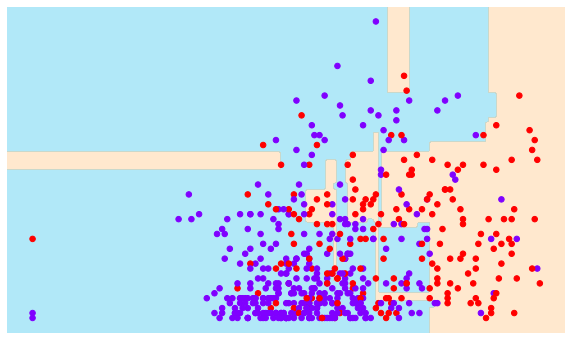

In [113]:
visualize_classifier(rnd_clf, X_train.values, y_train.values);

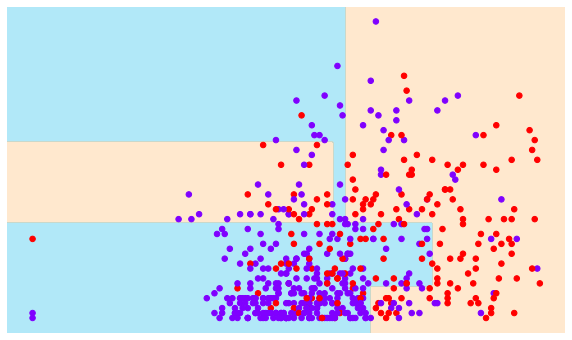

In [109]:
rnd_clf = RandomForestClassifier(n_estimators=1, max_leaf_nodes=8, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
visualize_classifier(rnd_clf, X_train.values, y_train.values);

Подберём гиперпараметры:

In [114]:
rf = RandomForestClassifier(random_state=42)
params_rf = {
    'n_estimators': [1, 5, 10, 50, 100, 200],
    'max_leaf_nodes':[4,8,16,32]
}
rf_gs = GridSearchCV(rf, params_rf, cv=5)
rf_gs.fit(X_train, y_train)
rf_best = rf_gs.best_estimator_
print(rf_gs.best_params_)

get_report(rf_best, X_test, y_test)

{'max_leaf_nodes': 8, 'n_estimators': 1}
              precision    recall  f1-score   support

           0     0.7466    0.7267    0.7365       150
           1     0.5176    0.5432    0.5301        81

    accuracy                         0.6623       231
   macro avg     0.6321    0.6349    0.6333       231
weighted avg     0.6663    0.6623    0.6641       231



Scoring - лучше ставить свой, потому что иначе будет использоваться тот, что по умолчанию у алгоритма обучения, а у RandomForestClassifier - accuracy.

In [115]:
rf = RandomForestClassifier(random_state=42)
params_rf = {'n_estimators': [1, 5, 10, 50, 100, 200],
            'max_leaf_nodes':[4, 8, 16, 32]}
rf_gs = GridSearchCV(rf, params_rf, cv=5, scoring='f1_micro')
rf_gs.fit(X_train, y_train)
rf_best = rf_gs.best_estimator_
print(rf_gs.best_params_)

get_report(rf_best, X_test, y_test)

{'max_leaf_nodes': 8, 'n_estimators': 1}
              precision    recall  f1-score   support

           0     0.7466    0.7267    0.7365       150
           1     0.5176    0.5432    0.5301        81

    accuracy                         0.6623       231
   macro avg     0.6321    0.6349    0.6333       231
weighted avg     0.6663    0.6623    0.6641       231



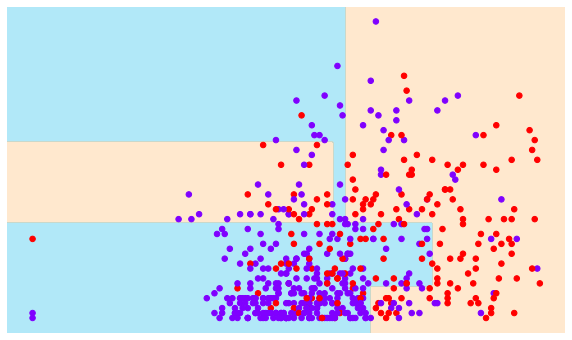

In [116]:
visualize_classifier(rf_best, X_train.values, y_train.values);

# Random forest regression

In [117]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

In [118]:
def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

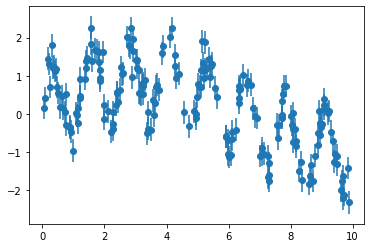

In [119]:
y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

In [124]:
x.shape

(200,)

In [123]:
x[:, None].shape

(200, 1)

In [121]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

RandomForestRegressor(n_estimators=200)

In [125]:
xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

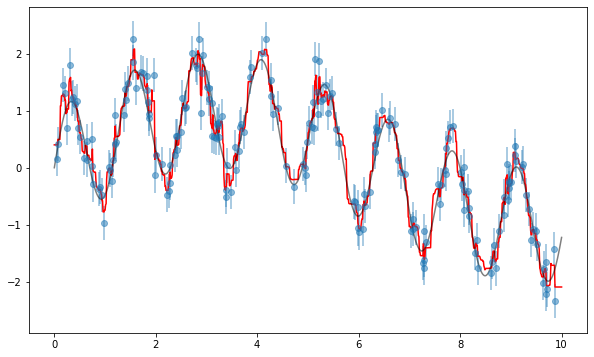

In [132]:
plt.figure(figsize=(10,6))
plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

# Random forest для классификаций картинок с цифрами

In [133]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [134]:
digits.data.max()

16.0

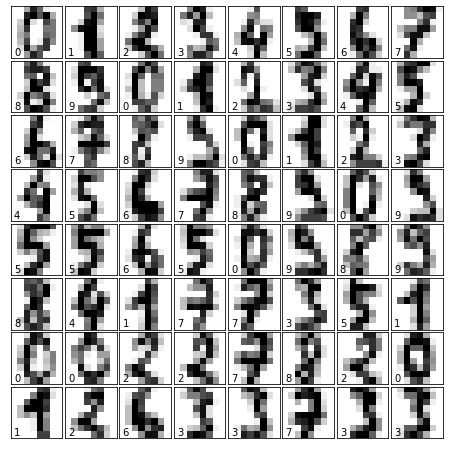

In [135]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

In [136]:
digits.data.shape

(1797, 64)

In [137]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

In [138]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       1.00      0.98      0.99        44
           2       0.95      1.00      0.98        42
           3       0.98      0.96      0.97        46
           4       0.97      1.00      0.99        37
           5       0.98      0.98      0.98        48
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



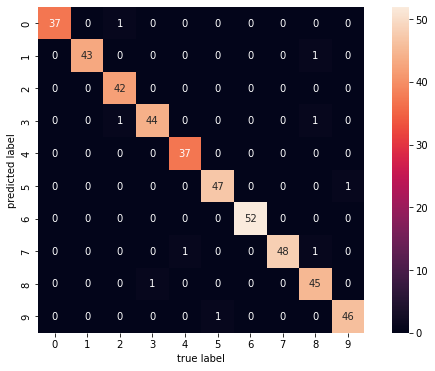

In [139]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(ytest, ypred)
plt.figure(figsize=(10,6))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True)
plt.xlabel('true label')
plt.ylabel('predicted label');